# Anomaly Detection For Timeseries of Networks

There is a particular type of sea slug which has gills on the outside of its body. When you squirt water at these gills, they withdraw into the slug. The interesting thing about this type of slug is that the brain network involved in this gill withdrawal reflex is entirely mapped out, from the neurons which detect and transmit information about the water into the slug's brain, to the neurons that leave the brain and fire at its muscles. (For those interested, this is a real thing - look up Eric Kandel's research on Aplysia!)

Say you're a researcher studying these sea slugs, and you have a bunch of brain networks of the same slug. We can define each node as a single neuron, and edges denote connections between neurons. Each of the brain networks that you have were taken at different time points: some before water started getting squirted at the slug's gills, and some as the water was getting squirted. Your goal is to reconstruct when water started to get squirted, using only the networks themselves. You hypothesize that there should be some signal change in your networks which can tell you the particular time at which water started getting squirted. Given the network data you have, how do you figure out which timepoints these are?

The broader class of problems this question addresses is called *anomaly detection*. The idea, in general, is that you have a bunch of snapshots of the same network over time. Although the nodes are the same, the edges are changing at each time point. Your goal is to figure out which time points correspond to the most change, either in the entire network or in particular groups of nodes. You can think of a network as "anomalous" with respect to time if some potentially small group of nodes within the network concurrently changes behavior at some point in time compared to the recent past, while the remaining nodes continue with whatever noisy, normal behavior they had.

In particular, what we would really like to do is separate the signal from the noise. All of the nodes in the network are likely changing a bit over time, since there is some variability intrinsic in the system. Random noise might just dictate that some edges get randomly deleted and some get randomly created at each step. We want to figure out if there are timepoints where the change isn't just random noise: we're trying to figure out a point in time where the probability distribution that the network *itself* is generated from changes.

Let's simulate some network timeseries data so that we can explore anomaly detection more thoroughly.

## Simulating Network Timeseries Data

For this data generation, we're going to assemble a set of 12 time-points for a network directly from its latent positions (we'll assume that each time-point for the network is drawn from an RDPG). Ten of these time points will just have natural variability, and two will have a subset of nodes whose latent positions were perturbed a bit. These two will be the anomalies.

We'll say that the latent positions for the network are one-dimensional, and that it has 100 nodes. There will be the same number of adjacency matrices as there are time points, since our network will be changing over time.

To make the ten non-anomalous time points, we'll:
1. Generate 100 latent positions. Each latent position will be a (uniformly) random number between 0.2 and 0.8.
2. Use graspologic's rdpg function to sample an adjacency matrix using these latent positions. Do this ten times.

And to make the two perturbed time points, we'll do the following twice:
1. Add a small amount of noise to the first 20 latent positions that we generated above.
2. Generate an adjacency matrix from this perturbed set of latent positions.

Once we have this simulated data, we'll move into some discussion about how we'll approach detecting the anomalous time points.

Below is code for generating the data. We define a function to generate a particular time-point, with an argument which toggles whether we'll perturb latent positions for that time point. Then, we just loop through our time-points to sample an adjacency matrix for each one.

In [1]:
import numpy as np
from graspologic.simulations import rdpg


def gen_timepoint(X, perturbed=False, n_perturbed=20):
    if perturbed:
        X = np.squeeze(X)
        baseline = np.array([1, -1, 0])
        delta = np.repeat(baseline, (n_perturbed//2, 
                                     n_perturbed//2, 
                                     nodes-n_perturbed))
        X += (delta * .15)
    if X.ndim == 1:
        X = X[:, np.newaxis]
    A = rdpg(X)
    return A
    

time_points = 12
nodes = 100
X = np.random.uniform(.2, .8, size=nodes)
networks = []

for time in range(time_points - 2):
    A = gen_timepoint(X)
    networks.append(A)

for perturbed_time in range(5, 7):
    A = gen_timepoint(X, perturbed=True)
    networks.insert(perturbed_time, A)
    
networks = np.array(networks)

You can see the adjacency matrices we generated below. Note that you can't really distinguish a difference between the ten normal time points and the two perturbed time points with the naked eye, even though the difference is there, so it would be pretty difficult to manually mark the time points - and if you have many time points, rather than just a few, you'd want to be able to automate the process.

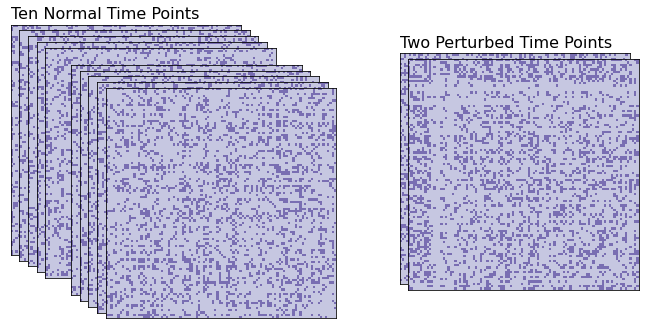

In [2]:
import matplotlib.pyplot as plt
from graphbook_code import heatmap, cmaps
import seaborn as sns

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)

fig = plt.figure();

# adjacency matrices
perturbed_points = {5, 6}
for i in range(time_points):
    if i not in perturbed_points:
        ax = fig.add_axes([.02*i, -.02*i, .8, .8])
    else:
        ax = fig.add_axes([.02*i+.8, -.02*i, .8, .8])
    ax = heatmap(networks[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Ten Normal Time Points", loc="left", fontsize=16)
    if i == 5:
        ax.set_title("Two Perturbed Time Points", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)

## How Do We Figure Out Which Time Points Are Anomalies?

It's time to start thinking about how we'd approach figuring out which of the time points are anomalies. 

One of the simplest approaches to this problem might just be to figure out which node has the highest count of edge changes across your timeseries. For each node across the timeseries, you'd count the number of new edges that appeared (compared to the previous point in time), and the number of existing edges that were deleted. Whichever count is highest could be your anomalous node.

This might give you a rough estimate -- and you could even potentially find perturbed time points with this approach -- but it's not necessarily the best solution. Counting edges doesn't account for other important pieces of information: for instance, you might be interested in which other nodes new edges were formed with. It seems like deleting or creating edges with more important nodes, for instance, should be weighted higher than deleting or creating edges with unimportant nodes.

So let's try another method. You might actually be able to guess it! The idea will be to simply estimate each network's latent positions, followed by a hypothesis testing approach. Here's the idea.

Let's call the latent positions for our network $X^{(t)}$ for the snapshot of the network at time $t$. You're trying to find specific time points, $X^{(i)}$, which are different from their previous time point $X^{(i-1)}$ by a large margin. You can define "different" as "difference in matrix norm". Remember that the matrix norm is just a number that generalizes the concept of vector magnitude to matrices. In other words, We're trying to find a time point where the difference in norm between the latent positions at time $t$ and the latent positions at time $t-1$ is greater than some constant:  $||X^{(t)} - X^{(t-1)}|| > c$. The idea is that non-anomalous time points will probably be a bit different, but that the difference will be within some reasonable range of variability.

There's an alternate problem where you restrict your view to *nodes* rather than entire adjacency matrices. The idea is that you'd find time-points which are anomalous for particular nodes or groups of nodes, rather than the entire network. The general idea is the same: you find latent positions, then test for how big the difference is between time point $t$ and time point $t-1$. This time, however, your test is for particular nodes. You want to figure out if $||X_i^{(t)} - X_i^{(t-1)}|| > c$, where you're looking at a particular latent position $X_i$ rather than all of them at once. We'll be focusing on the problem for whole networks, but you can take a look at the original paper if you're curious about how to apply it to nodes [cite]

## Detecting if the First Time Point is an Anomaly

We'll start with the first time point, which (because we generated the data!) we know in advance is not an anomaly.

If we were to just estimate the latent positions for each timepoint separately with ASE or LSE, we'd run into the nonidentifiability problem that we've seen a few times over the course of this book: The latent positions would be rotated versions of each other, and we'd have to use something like Procrustes (which adds variance, since it's just an estimate) to rotate them back into the same space.

However, since we have multiple time points, each of which is associated to an adjacency matrix, it's natural to use models from the Multiple-Network Representation Learning section (You can go back and read chapter 6.7 if you're fuzzy on the details here). In that section, we introduced the Omnibus Embedding as a way to estimate latent positions for multiple *networks* simultaneously, but all we really need for it is multiple *adjacency matrices*. These exist in our network in the form of its multiple time points; So, we'll just embed multiple time points at once with the Omnibus Embedding, and then they'll live in the same space.

We only really *need* to embed two time points at a time, since all we really care about is being able to directly compare a time point $X^{(t)}$ and the point prior to it $X^{(t-1)} = Y$ - but because of the way Omni works, we'll get smaller-variance estimates if we embed all the time points at once. Embedding them all at once also to be more robust to embedding dimension in practice. If you wanted to save computational power - for instance, if you had a lot of time points - you could instead choose to embed subsets of them, or just the two you'll actually be using.

So, here's what's going on in the code below:
1. We embed the time points using OMNI and then get our estimates for the first two sets of latent positions $\hat{X} = \hat{X}^{(t)}$ and $\hat{Y} = \hat{X}^{(t-1)}$.
2. Then, we get the norm of their difference $||\hat{X} - \hat{Y}||$ with numpy.

An important point to clarify is that there are a lot of different types of matrix norms: Frobenius norm, spectral norm, and so on. In our case, we'll be using the $l_2$ operator norm, which is simply the largest singular value of the matrix. The `ord` parameter argument in numpy determines which norm we use, and `ord=2` is the operator norm. 

Again, this norm, intuitively, will tell us how different two matrices are. If the norm of $X - Y$ is small, then $X$ and $Y$ are very similar matrices; whereas if the norm of $X - Y$ is large, then $X$ and $Y$ are very different. The norm should be large for anomalies, and small for everything else.

In [3]:
from graspologic.embed import OmnibusEmbed as OMNI

def get_statistic(adjacencies, return_latents=False):
    """
    Get the operator norm of the difference of two matrices.
    """
    omni = OMNI(n_components=1)
    latents_est = omni.fit_transform(adjacencies)
    Xhat, Yhat = latents_est[0], latents_est[1]
    y = np.linalg.norm(Xhat - Yhat, ord=2)
    if return_latents:
        return y, Xhat
    else:
        return y

y, Xhat = get_statistic(networks, return_latents=True)

In [4]:
print(f'{y:.3f}')

0.570


In [5]:
from myst_nb import glue
var = f'{y:.3f}'
glue("y", var, display=False)

'0.570'

## Hypothesis Testing With our Test Statistic

We have our norm $y$, which will be our test statistic. It should be a small value if the first two adjacency matrices in the timeseries are distributed the same, and large if they're distributed differently. Remember that we're fundamentally trying to figure out whether $X = X^{(t)}$, our latent positions at time $t$, is the same as $Y = X^{(t-1)}$, our latent positions at time $t-1$. This is also known as a *hypothesis test*: we're testing the the null hypothesis that $X = Y$ against the alternative hypothesis that $X \neq Y$.

The value of our test statistic is {glue:}`y`. The problem is that we don't know how big this is, relatively. Is {glue:}`y` relatively large? small? how should we determine whether it's small enough to say that X and Y probably come from the same distribution, and aren't anomaly time points?

Well, what if we could use our estimated latent positions $\hat{X}$ at time $t$ to generate a bunch of networks, then make test statistics from those new networks? We'd know for a fact that any pair of those networks are drawn from the same set of latent positions, and we could get a sense for what our test statistic should look like if the latent positions actually were the same. This technique is called *bootstrapping*, since you're using estimated parameters to "pull yourself up by your own bootstraps" and generate a bunch of artificial data. Bootstrapping pops up all over the place in machine learning and statistics contexts.

### Using Bootstrapping to Figure out the Distribution of the Test Statistic

We don't have the true latent positions for a given time point, but we do have the estimated latent positions (we just used OMNI embedding to find them!)

So what we can do is the following:
1. Using a set of the latent positions we just estimated, generate two new adjacency matrices.
2. Get the test statistic for these two adjacency matrices.
3. Repeat 1) and 2) a bunch of times, getting new test statistics each time
4. Look at the distribution of these test statistics, and determine whether {glue:}y is an outlier or not with respect to this distribution.

So we're artificially generating data that we *know for a fact* is distributed in exactly the same way, and then looking at how our test statistic is distributed under those assumptions. This artificial data will necessarily be a bit biased, since the latent positions you're using to generate it are themselves only estimates, but it should be close enough to the real thing to be useful.

Below is some code. We generate 1000 pairs of adjacency matrices from our estimated latent positions for the first time point $\hat{X}^{(t)}$, and get the test statistic for each pair. Underneath this looping code, you can see the distribution of these bootstrapped test statistics in the form of a histogram. They look roughly normally distributed, and hover around 0.60. The red line shows where our actual test statistic lies, where we compare $\hat{X}^{(t)}$ to $\hat{X}^{(t-1)}$.

If the red line is super far away from the bulk of the mass in the test statistic distribution, then it would be fairly unlikely to be drawn from the same set of latent positions as the bootstrapped test statistics, and we'd reject the hypothesis that it is. If it's well within the range of values we'd reasonably expect, then we wouldn't reject this possibility. 

In [6]:
# null hypothesis that X = Y. Bootstrap X.
N = 1000
bootstraps = []
for est in range(N):
    A_est = rdpg(Xhat)
    B_est = rdpg(Xhat)
    bootstrapped_y = get_statistic([A_est, B_est])
    bootstraps.append(bootstrapped_y)
bootstraps = np.array(bootstraps)

Text(0.5, 20, 'Bootstrapped Distribution')

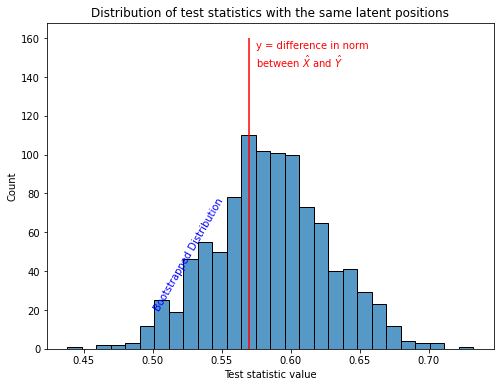

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

plot = sns.histplot(bootstraps, ax=ax)
plot.set_title("Distribution of test statistics with the same latent positions");
plot.set_xlabel("Test statistic value");

plot.vlines(y, 0, 160, colors='r')
plot.annotate("y = difference in norm \nbetween $\hat{X}$ and $\hat{Y}$", (y+.005, 145), c='r');
plot.text(.50, 20, "Bootstrapped Distribution", color="blue", rotation=60)

Fortunately, {glue:}`y` is well within a reasonable range under the assumption that the time-points share latent positions. However, we can't always eyeball stuff, and we need a way to formalize what it means for a test statistic to be "within a reasonable range". Our test statistic is  $y = ||X^{(t)} - X^{(t-1)}||$, we're trying to figure out if $X^{(t)} = X^{(t-1)}$, and we have a bunch of bootstrapped test statistics that we know were drawn from the same distribution (and are thus examples of the case where the null hypothesis is true).

## Using our test statistic to find p-values

Since we have a range of examples of $y$ values in which the null hypothesis is true, we have an estimate for the distribution of the null hypothesis. So, to find the probability that any new value drawn from this bootstrapped distribution is greater than a particular value $c$, we can just find the proportion of our bootstrapped values that are greater than $c$.

\begin{align*}
    p &= \frac{\textrm{number of bootstrapped values greater than $c$}}{\textrm{total number of bootstrapped values}}
\end{align*}

When we let $c$ be equal to our test statistic, $y$, we find the probability that any new bootstrapped value will be greater than $y$ (assuming that $y$ is drawn from the null distribution). Here we have our formalization.

Below is some simple numpy code that performs this estimation. We just count the number of bootstrapped statistics that are greater than our $y$ value, and then divide by the number of bootstrapped test statistics. If the resulting $p$-value is less than some pre-determined probability (say, for instance, $0.05$), then we reject the null hypothesis and say that $y$ probably comes from a different distribution than the bootstrapped statistics. This, in turn, implies that $X^{(t)} \neq X^{(t-1)}$, and we've found an anomaly time point.

In [8]:
p = (bootstraps > y).sum() / N

print(p)

0.651


Our $p$ value is much larger than 0.05, so we don't reject the null hypothesis, and we can conclude that we haven't found an anomaly time. Since this is all synthetic data, we know how the data generation process worked, so we actually know for a fact that this is the right result -- the adjacency matrix at time $t$ actually *was* drawn from the same distribution as the adjacency matrix at time $t-1$.

## Testing the Rest of the Time Points For Anomalies

Now that we've gone through this for one time point, we can do it for the rest. The process is exactly the same, except that you're comparing different pairs of timepoints and you're generating the bootstrapped test statistics with different estimated latent positions.

Below we get our test statistic for every pair of time points. Our two anomaly time points are drawn from the same distribution, by design, so we shouldn't catch an anomaly when we test them against each other; however, we should catch anomalies when we test them against other, non-anomaly time points, and that's exactly what we see.

In [9]:
ys_true = {}
for i, adjacency in enumerate(networks[1:]):
    y = get_statistic([adjacency, networks[i-1]])
    ys_true[f"{i}:{i+1}"] = float(f"{y:.3f}")

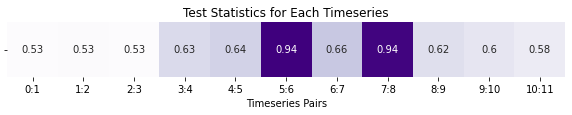

In [10]:
from graphbook_code import cmaps

data = np.fromiter(ys_true.values(), dtype=float)

fig, ax = plt.subplots(figsize=(10, 1))
plot = sns.heatmap(data[:, None].T, cmap=cmaps["sequential"], 
                   cbar=False, annot=True);
plot.set_title("Test Statistics for Each Timeseries");
plot.axes.yaxis.set_ticklabels([]);
plot.axes.xaxis.set_ticklabels(list(ys_true.keys()));
plot.set_xlabel("Timeseries Pairs");

If we were to plot a distribution of bootstrapped test statistics with each of our estimated y-values, it would look like the histogram below. Notice that two test statistics are clearly anomalous: the one comparing times five and six, and the one comparing times seven and eight. We know by design that networks six and seven actually are anomolous, and so we can see that our test managed to correctly determine the anomaly times.

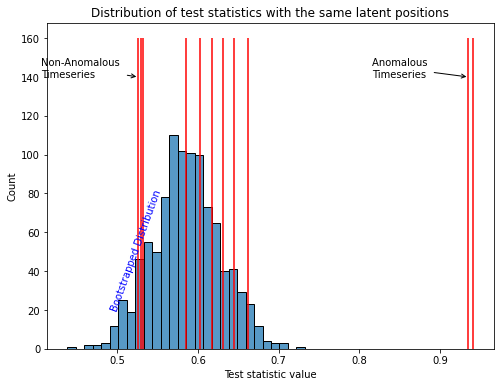

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

plot = sns.histplot(bootstraps, ax=ax)
plot.set_title("Distribution of test statistics with the same latent positions");
plot.set_xlabel("Test statistic value");

for y_val in data:
    plot.vlines(y_val, 0, 160, colors='r');
    
sorted_ys = np.sort(np.fromiter(ys_true.values(), dtype=float))
x_min = sorted_ys[0]
x_max = sorted_ys[-2]
plot.annotate("Non-Anomalous \nTimeseries", xy=(x_min, 140), xytext=(x_min-.12, 140), 
              arrowprops={"arrowstyle": "->", "color":"k"})

plot.annotate("Anomalous \nTimeseries", xy=(x_max, 140), xytext=(x_max-.12, 140), 
              arrowprops={"arrowstyle": "->", "color":"k"});

plot.text(.49, 20, "Bootstrapped Distribution", color="blue", rotation=70);

## The Distribution of the Bootstrapped Test Statistic

One issue that could pop up is that the bootstrapped test statistic is slightly biased. Since we're generating it from an estimate $\hat{X}$ of the true latent positions $X$, we'll have a bias of $|\hat{X} - X|$. It's worth comparing the two distributions to determine if that bias is a big deal in practice.

Below you can see the true distribution of the test statistic for the real, unperturbed set of latent positions $X$ we generated the data from (that's the blue distribution). You can also see a distribution of test statistics bootstrapped from a $\hat{X}$. You can see that in this case, they're fairly close.

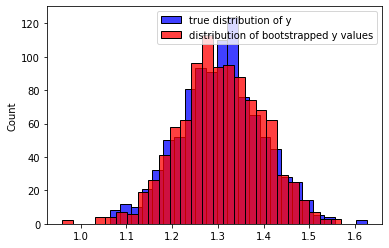

In [12]:
from graspologic.simulations import rdpg
import numpy as np
from graspologic.embed import OmnibusEmbed as OMNI

X = np.random.uniform(.2, .8, size=(100, 1))
networks = []
networks.append(rdpg(X))
networks.append(rdpg(X))

def get_statistic(adjacencies, return_latents=False):
    """
    Get the operator norm of the difference of two matrices.
    """
    omni = OMNI(n_components=2)
    latents_est = omni.fit_transform(adjacencies)
    X, Y = latents_est[0], latents_est[1]
    y = np.linalg.norm(X - Y, ord=2)
    if return_latents:
        return y, X
    else:
        return y

omni = OMNI(n_components=1)
latents = omni.fit_transform(networks)

ys_bootstrap = []
for i in range(1000):
    A_, B_ = rdpg(latents[0]), rdpg(latents[0])
    y_ = get_statistic([A_, B_])
    ys_bootstrap.append(y_)
    
ys_true = []
for i in range(1000):
    A_, B_ = rdpg(X), rdpg(X)
    y_ = get_statistic([A_, B_])
    ys_true.append(y_)
    
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ys_true, label="true distribution of y", color="blue")
sns.histplot(ys_bootstrap, label="distribution of bootstrapped y values", color="red")

plt.gca().legend()

## 

## References



- j1's paper -- heritability
- vivek's paper -- mcc

## Notes

guodong's stuff: uses MASE and OMNI combined with DCORR to do hypothesis testing
- vivek did something similar for MCC